## 物体（自動車）検知Scoring APIへのリクエスト、ボックスの重ね合わせ画像の保存

ドキュメント：https://docs.h2o.ai/h2o-hydrogen-torch/tutorials/predictions/tutorial-2b

In [1]:
import os
import base64
import json
import requests

import cv2
import pandas as pd
import numpy as np

import torch
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

In [2]:
# パラメータ

URL = 'https://model.internal.dedicated.h2o.ai/bffea6ac-818e-41bd-81d8-aba7228929e3/model/score'   # APIエンドポイント

# current directory上の元画像と結果画像のフォルダ
IMG_IN = 'images'
IMG_OUT = 'images_out'

img_path = 'traffic-0.jpg'    # スコアリング用画像ファイル
file_name = os.path.splitext(img_path)
img_path = os.path.join(IMG_IN, img_path)
print(img_path)

img_out_path = file_name[0] + '_box.jpg'
img_out_path = os.path.join(IMG_OUT, img_out_path)
print(img_out_path)

conf_threshold = 0.5    # バウンディングボックスのConfidence閾値

images/traffic-0.jpg
images_out/traffic-0_box.jpg


In [3]:
# スコアリング用画像の読み込み

img = cv2.imread(img_path)
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(450, 800, 3)


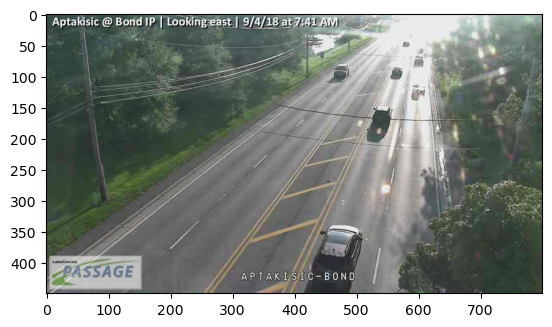

In [4]:
# 元画像を表示する場合

import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
# 画像データをbase64でエンコード
img_encode = base64.b64encode(cv2.imencode(".png", img)[1]).decode()
print(type(img_encode))
img_encode[:30]

<class 'str'>


'iVBORw0KGgoAAAANSUhEUgAAAyAAAA'

In [6]:
# APIにPOSTするjsonデータ
data = {"fields": ["input"], "rows": [[img_encode]]}

In [9]:
%%time

# APIへのPOSTリクエスト（スコアリングの実施）
r = requests.post(url=URL, json=data)
r

CPU times: user 47.5 ms, sys: 4.29 ms, total: 51.8 ms
Wall time: 4.1 s


<Response [200]>

In [10]:
# 取得結果の加工
ret = r.json()  
print(type(ret))
ret.keys()

<class 'dict'>


dict_keys(['fields', 'id', 'score'])

In [11]:
ret['fields']

['output']

In [12]:
ret['id']

'89e13a2c-eb98-485f-8fde-62a5cda09b42'

In [13]:
# 'boxes' : バウンディングボックス座標
# 'confidences' : Confidence. Confidenceの大きい順にソートされている
# 'classes' : 0:自動車、-1:無し

ret_json = json.loads(ret["score"][0][0])
print(ret_json.keys())
ret_json

dict_keys(['boxes', 'confidences', 'classes'])


{'boxes': [[[461.98773193359375,
    80.77716064453125,
    489.1857604980469,
    104.28378295898438],
   [430.59564208984375,
    339.846923828125,
    511.13043212890625,
    437.4839782714844],
   [555.4920654296875, 86.11515808105469, 575.67626953125, 105.9002685546875],
   [572.7815551757812,
    44.35810852050781,
    586.8984985351562,
    54.139060974121094],
   [525.6483764648438,
    148.7996826171875,
    556.7987060546875,
    191.00486755371094],
   [590.7269897460938,
    111.32444763183594,
    612.62744140625,
    129.36940002441406],
   [592.3855590820312, 68.62149810791016, 609.8828125, 82.8163070678711],
   [419.87646484375, 37.0936393737793, 448.483642578125, 52.888248443603516],
   [799.7052001953125,
    446.01092529296875,
    799.9998168945312,
    449.9857177734375],
   [601.8465576171875, 55.7872428894043, 616.931884765625, 67.01255798339844],
   [589.860595703125, 117.7957534790039, 611.741943359375, 137.67135620117188],
   [427.01837158203125, 41.5517578125

In [17]:
pd.DataFrame({'boxes':ret_json['boxes'][0], 'confidences':ret_json['confidences'][0], 'classes':ret_json['classes'][0]})

# デフォルトで100オブジェクト返る

,boxes,confidences,classes
0,"[461.98773193359375, 80.77716064453125, 489.18...",0.997219,0
1,"[430.59564208984375, 339.846923828125, 511.130...",0.995994,0
2,"[555.4920654296875, 86.11515808105469, 575.676...",0.971040,0
3,"[572.7815551757812, 44.35810852050781, 586.898...",0.962054,0
4,"[525.6483764648438, 148.7996826171875, 556.798...",0.925344,0
...,...,...,...
95,"[0.0, 0.0, 0.0, 0.0]",0.000000,-1
96,"[0.0, 0.0, 0.0, 0.0]",0.000000,-1
97,"[0.0, 0.0, 0.0, 0.0]",0.000000,-1
98,"[0.0, 0.0, 0.0, 0.0]",0.000000,-1


In [18]:
# conf_threshold以上のデータのみ取得
print(conf_threshold)

conf = np.array(ret_json['confidences'][0] )[np.array(ret_json['confidences'][0] ) >= conf_threshold]   # conf_threshold以上のConfidence
b_boxes = np.array(ret_json['boxes'][0])[np.array(ret_json['confidences'][0] ) >= conf_threshold]   # conf_threshold以上のボックス
count = len(conf)  # ボックスの数

0.5


In [19]:
img_t = read_image(img_path)     # torch.Tensorとして画像を読み込む
print(type(img_t))
img_t.size()

<class 'torch.Tensor'>


torch.Size([3, 450, 800])

In [20]:
# 画像とボックスの重ね合わせ
img_with_box = draw_bounding_boxes(
    image=img_t,
    boxes=torch.from_numpy(b_boxes), 
    #labels=[str(i) for i in conf],   # Confidenceをラベルとする場合
    colors="red",
)
print(img_with_box.shape)

img_with_box = to_pil_image(img_with_box)    # PIL imageへ変換

torch.Size([3, 450, 800])


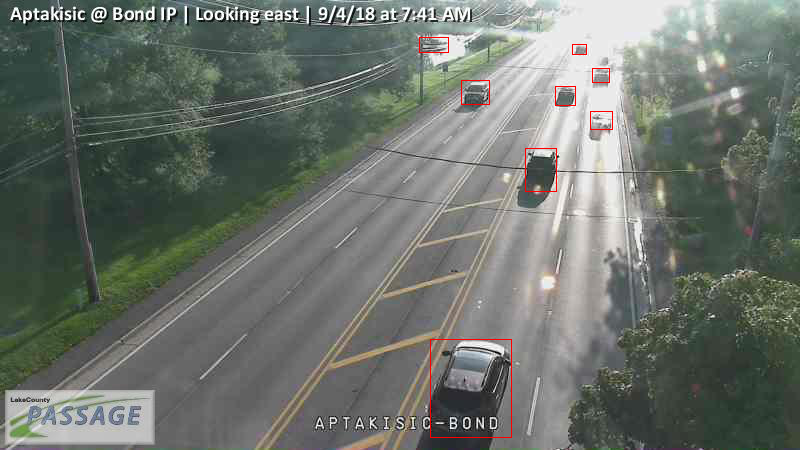

ボックスの数：8


In [21]:
display(img_with_box)
print('ボックスの数：{}'.format(count))

In [22]:
# 画像の保存
img_with_box.save(img_out_path)